## Imports

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from os import listdir
from os.path import isfile, join
from PIL import Image
from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time as time
import copy
from torchvision.datasets import OxfordIIITPet
from torch.optim import lr_scheduler

from tqdm import tqdm

## Fields

In [134]:



num_classes = 37 #Number of classes in dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 224
batch_size = 128

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

path = ""

## Methods

In [135]:
def set_parameter_requires_grad(model, feature_extracting):
    params_to_update = list(model.named_parameters())
    
    if feature_extracting:
        for name, param in params_to_update:
            param.requires_grad = False      
    else:
        for module, param in zip(model.modules(), model.parameters()):
            if isinstance(module, nn.BatchNorm2d):
                param.requires_grad = False
            else:
                param.requires_grad = True
            



def initialize_model(model_name, num_classes, feature_extracting): #Initialize Resnet

    if model_name == "resnet":

        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) 
        
        set_parameter_requires_grad(model, feature_extracting)
        
        num_ftrs = model.fc.in_features
        head = nn.Sequential(nn.BatchNorm1d(num_ftrs),
                             nn.ReLU(),
                             nn.Dropout(0.25),
                nn.Linear(num_ftrs, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes))
        
        #model.fc = nn.Linear(num_ftrs,num_classes) # Update last layer to binary classification (Dog/cat)
        model.fc = head#nn.Linear(num_ftrs,num_classes) # Update last layer to binary classification (Dog/cat)
        input_size = 224 #"Finally, notice that inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224)."
        model = model.to(device)
        
    return model, input_size



def readData(target_type):# = 'breeds'):
    breed_to_species = {0:0, 1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:0, 8:1, 9:0, 10:1,
                    11:0, 12:1, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1, 20:0,
                    21:1, 22:1, 23:0, 24:1, 25:1, 26:0, 27:0, 28:1, 29:1, 30:1,
                    31:1, 32:0, 33:0, 34:1, 35:1, 36:1
                   }
    
    transform_train = T.Compose([
                           #T.Resize(256),
                            T.Resize(image_size),

                           T.CenterCrop(image_size),
                           #T.RandomHorizontalFlip(p=0.5),
                           ##T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                           #T.RandomRotation(degrees=90),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           #T.RandomResizedCrop(size=image_size)
                          ])
    

    
    transform_test = T.Compose([T.Resize(image_size),
        #T.Resize(256),
                            T.CenterCrop(image_size),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          ])
    if target_type == 'species':
        target_function = (lambda x: breed_to_species.get(x))
    elif target_type == 'breeds':
        target_function = None
    else:
        raise Exception("Wrong target type")
        
    trainval = OxfordIIITPet(path,
                             target_types= "category",
                             transform=transform_train,
                             split = 'trainval',
                             target_transform = target_function
                            )
    test = OxfordIIITPet(path,
                         target_types= "category",
                         transform=transform_test,
                         split = 'test',
                         target_transform = target_function
                        )
                         
    #train, val = splitData(trainval, 0.95, 0.05)
    return trainval, test #train, val, test
    
def splitData(dataset,nrTrain,nrVal):
    len1 = int(nrTrain*len(dataset))
    len2 = int(len(dataset) - len1)
    train, val = torch.utils.data.random_split(dataset, [len1,len2])
    return train, val

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))




In [136]:
def train_model(model, dataloaders, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()
    loss_history = []
    val_acc_history = []
    acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()

                # statistics
                running_loss += float(loss.item() * inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)
                
            #if phase == 'train' and scheduler == None:
                #scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            loss_history.append(epoch_loss)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            acc_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, val_acc_history,loss_history,acc_history

In [137]:
def score(model, dataloader, criterion):
    running_corrects = 0

    with torch.no_grad():
        model.eval()
        for inputs, labels in tqdm(dataloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print('Acc: {:4f}'.format(acc))

## Model evaluation

In [138]:
train, val    = readData(
                            #target_type = 'species'
                            target_type = 'breeds'
                            )

In [139]:
#train, _ = splitData(train, 0.20, 0.8)
#val, _ = splitData(val, 0.20,0.8)

In [140]:
model,input_size = initialize_model(model_name = "resnet",
                                    num_classes = 37,
                                    feature_extracting = True)


dataloaders = {label: torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
          for label, data in zip(['train', 'val'],[train, val])}

test_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
epochs = 10
criterion = nn.CrossEntropyLoss()

Using cache found in C:\Users\GTSA - Infinity/.cache\torch\hub\pytorch_vision_v0.10.0


In [141]:



optimizer = optim.Adam(model.parameters(),
                       lr=1e-3, 
                       #weight_decay=1e-5,
                       #betas=(0.9, 0.999),
                      )





scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-2,
                                                steps_per_epoch=len(dataloaders['train']), epochs=epochs)


model, val_acc_history, loss_history, acc_history = train_model(model = model,
                                          num_epochs = epochs,
                                          dataloaders = dataloaders,
                                          criterion = criterion,
                                          optimizer = optimizer,
                                          scheduler = None#scheduler
                                        )

Epoch 0/9
----------
train Loss: 3.1194 Acc: 0.2313
val Loss: 2.3924 Acc: 0.6773
Epoch 1/9
----------
train Loss: 2.0821 Acc: 0.6277
val Loss: 1.5538 Acc: 0.7896
Epoch 2/9
----------
train Loss: 1.5304 Acc: 0.7383
val Loss: 1.1476 Acc: 0.8316
Epoch 3/9
----------
train Loss: 1.1682 Acc: 0.7984
val Loss: 0.8978 Acc: 0.8539
Epoch 4/9
----------
train Loss: 0.9313 Acc: 0.8291
val Loss: 0.7340 Acc: 0.8697
Epoch 5/9
----------
train Loss: 0.7776 Acc: 0.8514
val Loss: 0.6264 Acc: 0.8752
Epoch 6/9
----------
train Loss: 0.6653 Acc: 0.8652
val Loss: 0.5503 Acc: 0.8806
Epoch 7/9
----------
train Loss: 0.5753 Acc: 0.8842
val Loss: 0.5054 Acc: 0.8828
Epoch 8/9
----------
train Loss: 0.5157 Acc: 0.8872
val Loss: 0.4663 Acc: 0.8863
Epoch 9/9
----------
train Loss: 0.4680 Acc: 0.8973
val Loss: 0.4447 Acc: 0.8809
Training complete in 6m 49s
Best val Acc: 0.886345


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

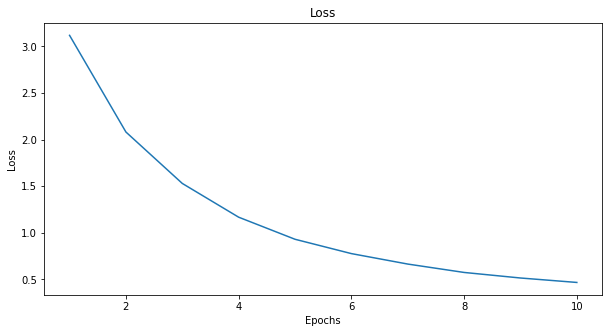

In [157]:
#score(model, test_dataloader, criterion)

yvals = list(range(1,epochs+1))
newloss = []
newacc = []
for i in range(len(loss_history)):
    if i % 2 == 0:
        newloss.append(loss_history[i])
        newacc.append(acc_history[i])

plot1 = plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(yvals,newloss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

print(yvals)
print(acc_history[0].cpu().items())
plot2 = plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(yvals,newacc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'tensor')

In [ ]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)

layer_names.reverse()

# learning rate
lr      = 1e-4
lr_mult = 0.9

# placeholder
parameters = []

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
    
    # update learning rate
    lr *= lr_mult

optimizer = optim.Adam(parameters)

In [ ]:
set_parameter_requires_grad(model, False)

    
"""optimizer = optim.Adam(model.parameters(),
                       lr=1e-6, 
                       weight_decay=1e-5,
                       betas=(0.9, 0.999),
                      )"""

finetune_epochs = 7
"""scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-4,
                                                steps_per_epoch=len(dataloaders['train']),
                                                epochs=finetune_epochs)"""

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

best_model, val_acc_history, loss_history, acc_history = train_model(model = model,
                                          num_epochs = finetune_epochs,
                                          dataloaders = dataloaders,
                                          criterion = criterion,
                                          optimizer = optimizer,
                                          scheduler = scheduler
                                        )

In [ ]:
score(best_model, test_dataloader, criterion)